<a href="https://colab.research.google.com/github/AndresPerelmuter/Clustering/blob/main/Cluster_H%26M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentación de Clientes**
---

1 - Objetivo

2 - Comprensión de los datos

3 - Preparación de los datos

4 - Modelado

5 - Insights


## **1 - Objetivo**
---

El objetivo de este trabajo es lograr un mayor conocimiento de los clientes, que permita el despliegue de estrategias de venta que se ajusten a sus características, así como mejorar la toma de decisiones.

Los datos que se utilizaron en este proyecto fueron obtenidos de la plataforma Kaggle (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview).



## **2 - Comprensión de los Datos**

---




Los datos corresponden a transacciones realizadas entre octubre del 2018 y octubre del 2020.

**Instalación y carga de librerias**

In [1]:
!pip install pyclustertend
!pip install yellowbrick 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 109.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 120.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-l

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import iplot
import plotly.graph_objs as go

from sklearn.metrics import pairwise_distances_argmin_min
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from scipy.spatial.distance import pdist, cdist
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Funciones a utilizar**

In [4]:
def val_nulos(df):
    s1 = df.isnull().sum().rename('Missing Values')
    return pd.DataFrame(s1)

**Recopilación de datos Iniciales**

In [5]:
transactions = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
articles = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = transactions[(transactions['t_dat'] < '2019-11-01')]

In [6]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [7]:
transactions.shape

(18491844, 5)

In [8]:
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [9]:
customers['club_member_status'].value_counts()

ACTIVE        1272491
PRE-CREATE      92960
LEFT CLUB         467
Name: club_member_status, dtype: int64

In [10]:
customers.shape

(1371980, 7)

In [11]:
articles.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [12]:
articles.shape

(105542, 25)

**Exploración de los Datos**







In [13]:
transactions.describe()

,article_id,price,sales_channel_id
count,1.849184e+07,1.849184e+07,1.849184e+07
mean,6.507392e+08,2.792349e-02,1.693333e+00
std,1.169432e+08,1.979836e-02,4.611099e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,5.995800e+08,1.523729e-02,1.000000e+00
50%,6.811810e+08,2.540678e-02,2.000000e+00
75%,7.283800e+08,3.388136e-02,2.000000e+00
max,8.561730e+08,5.915254e-01,2.000000e+00


In [14]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

Se analiza la distribución de los precios en el dataset de transacciones visualizandose outliers.

<AxesSubplot:ylabel='price'>

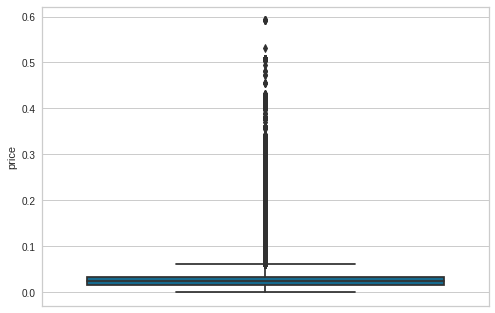

In [15]:
sns.boxplot(y = transactions['price'])

<AxesSubplot:xlabel='price', ylabel='Count'>

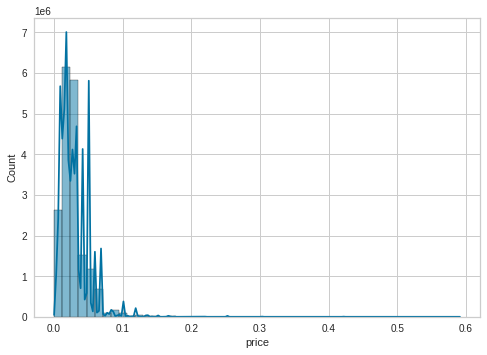

In [16]:
sns.histplot(data=transactions, x="price", palette='winter', bins=50, kde=True)

Se realiza un análisis de los precios promedio por artículo asi como el mínimo y máximo.

In [17]:
preciopart = transactions.groupby('article_id', as_index=False).agg(
    Precio_Prom=('price', 'mean'),
    Min_Precio=('price', min),
    Max_Precio=('price', max))
preciopart

,article_id,Precio_Prom,Min_Precio,Max_Precio
0,108775015,0.008149,0.001339,0.009153
1,108775044,0.008134,0.001678,0.008508
2,108775051,0.004980,0.003237,0.008458
3,110065001,0.021511,0.002525,0.025407
4,110065002,0.019296,0.005085,0.025407
...,...,...,...,...
74723,853752001,0.032273,0.027593,0.033881
74724,853932001,0.049077,0.040661,0.050831
74725,854576001,0.041593,0.041593,0.041593
74726,854576003,0.040661,0.033881,0.042356


In [18]:
preciopartdate = transactions.groupby(['t_dat', 'article_id'], as_index=False).agg(
    Precio_Prom=('price', 'mean'),
    Min_Precio=('price', min),
    Max_Precio=('price', max))

In [19]:
preciopartdate

,t_dat,article_id,Precio_Prom,Min_Precio,Max_Precio
0,2018-09-20,108775015,0.008445,0.008068,0.008458
1,2018-09-20,108775044,0.008458,0.008458,0.008458
2,2018-09-20,108775051,0.004929,0.004695,0.005068
3,2018-09-20,110065001,0.023500,0.022864,0.025407
4,2018-09-20,110065002,0.023147,0.021169,0.025407
...,...,...,...,...,...
4395304,2019-10-31,853752001,0.032288,0.031627,0.032949
4395305,2019-10-31,853932001,0.050831,0.050831,0.050831
4395306,2019-10-31,854576001,0.041593,0.041593,0.041593
4395307,2019-10-31,854576003,0.040661,0.033881,0.042356


A continuación, se crea una nueva columna con número de transacción (fecha y número de cliente) con el objetivo de analizar la cantidad de artículos comprados por transacción a efectos de analizar posibles fraudes o errores en la información.

Aqui se ven valores atípicos como la compra de 540 artículos en una transacción. En siguientes puntos se tratará este tema como outliers.

In [20]:
transactions['n_trans'] = transactions['t_dat'] + transactions['customer_id']
trans_dia = transactions.groupby('n_trans', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)

In [21]:
trans_dia.sort_values(by=['Cantidad'], ascending=False)
trans_dia

,n_trans,Cantidad
330656,2018-10-14d00063b94dcb1342869d4994844a2742b5d6...,570
1161741,2018-12-17c2f0cdda2dc3042ccd9fcd8253fd8e368769...,336
1489900,2019-01-1362fd7d41b587c72a95c31eca5046019ce4e8...,221
333665,2018-10-15246734d8f4a4252fcd5c7aa525055a2804b9...,220
1869380,2019-02-1694665b46e194622ccdbcadc0170f13a2f8ed...,199
...,...,...
3866531,2019-07-1480282b0e1aa004db17ad2ffa8800d7867182...,1
1675224,2019-01-30069648ee5e6b6924829016a760a3c71dff96...,1
1675225,2019-01-300698e1cbddeb7184ec72ab5ff92952620427...,1
1675226,2019-01-3006afdf7824c7a7fc828c36ca23aa51da0d5b...,1


<AxesSubplot:xlabel='Cantidad'>

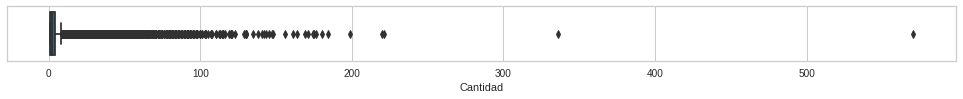

In [22]:
plt.figure(figsize=(17,1))
sns.boxplot(x = trans_dia['Cantidad'])

In [23]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [24]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

<AxesSubplot:ylabel='age'>

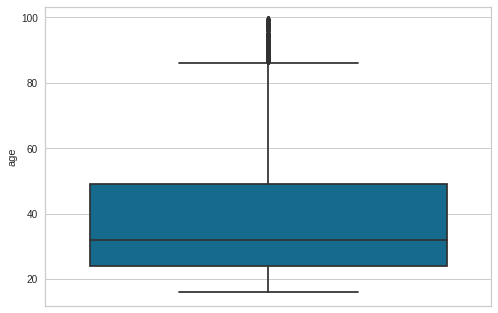

In [25]:
sns.boxplot(y = customers['age'])

Se observan dos segmentos de clientes, uno de ellos entre los 20 y 35 años y el restante entre los 45 años y 60 años. 

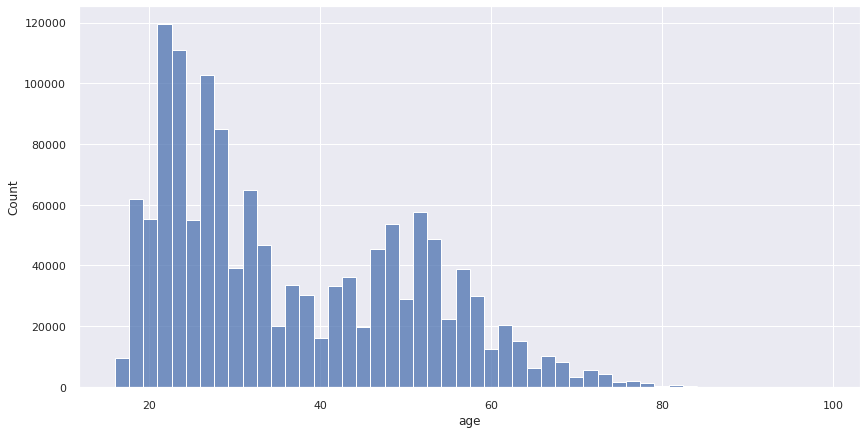

In [26]:
plt.figure(figsize=(14, 7))

sns.set(style="darkgrid")

sns.histplot(data=customers, x="age", bins=50)
plt.show()

In [27]:
articles.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [28]:
articles.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

A continuación, se detalla la cantidad de artículos que se comercializan por tipo de cliente.

In [29]:
art = articles.groupby('index_group_name', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)
art

,index_group_name,Cantidad
2,Ladieswear,39737
0,Baby/Children,34711
1,Divided,15149
3,Menswear,12553
4,Sport,3392


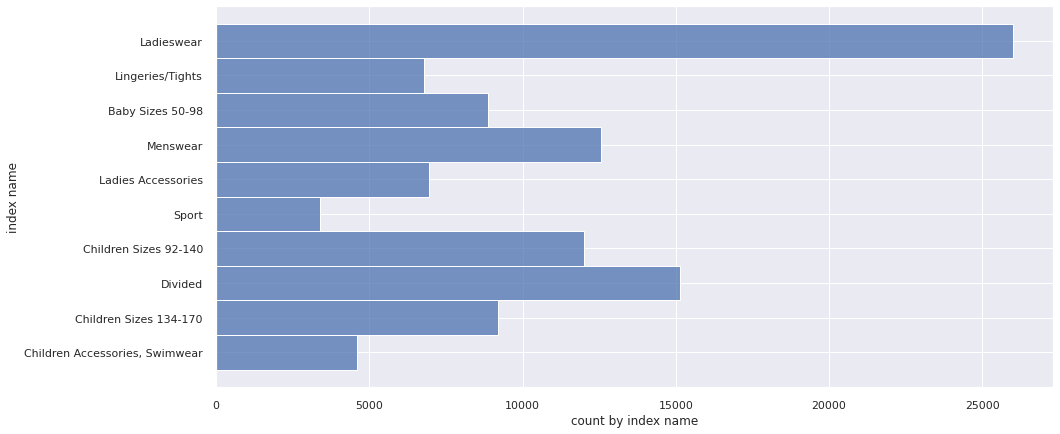

In [30]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='index_name')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

### **3. Preparación de los Datos**

---



**Limpieza de Datos**

In [31]:
val_nulos(transactions)

,Missing Values
t_dat,0
customer_id,0
article_id,0
price,0
sales_channel_id,0
n_trans,0


In [32]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

In [34]:
val_nulos(customers)

,Missing Values
customer_id,0
FN,895050
Active,907576
club_member_status,6062
fashion_news_frequency,16009
age,15861
postal_code,0


In [35]:
customers['age']=customers['age'].fillna(customers['age'].mean())

In [36]:
customers['age'] = customers['age'].astype(np.int64)

In [37]:
customers['FN']=customers['FN'].fillna(0)
customers['Active']=customers['Active'].fillna(0)

In [38]:
val_nulos(articles)

,Missing Values
article_id,0
product_code,0
prod_name,0
product_type_no,0
product_type_name,0
product_group_name,0
graphical_appearance_no,0
graphical_appearance_name,0
colour_group_code,0
colour_group_name,0


In [39]:
aux1 = pd.merge(transactions[["customer_id", 'price', "sales_channel_id"]], customers[["customer_id",'age']])
aux1 = pd.DataFrame(aux1.groupby(['age', "sales_channel_id"], as_index=False).agg(ventas=('price', sum)))

# Create new dataframe column with the labels instead of numbers
aux1["sales_channel_id"] = aux1['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
aux1.rename(columns={"sales_channel_id": "Canal Venta"}, inplace = True)
aux1['age'] = aux1['age'].astype('Int64', errors='ignore' )
aux1 = aux1[aux1.age < 70]

Se detallan las ventas por edad y canal de venta entre el año 2018 y 2020. Se observa que dos tercios de las ventas de los clientes entre los 20 y 40 años compran en forma online.

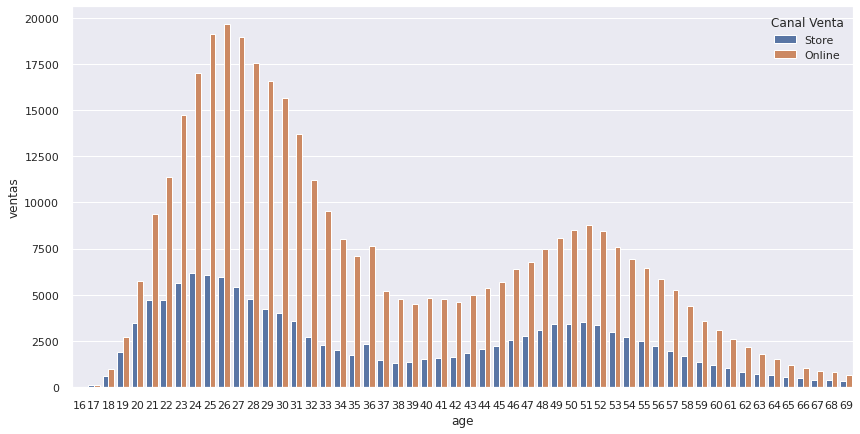

In [40]:
plt.figure(figsize=(14, 7))

bar1 = sns.barplot(x="age",  y="ventas", hue = 'Canal Venta', data=aux1, saturation=0.75, errcolor='.26')

plt.show()

In [41]:
aux2 = pd.merge(transactions[["article_id", 'price']], articles[["article_id",'index_group_name']])
aux2 = aux2.groupby('index_group_name', as_index=False).agg(ventas=('price', sum))

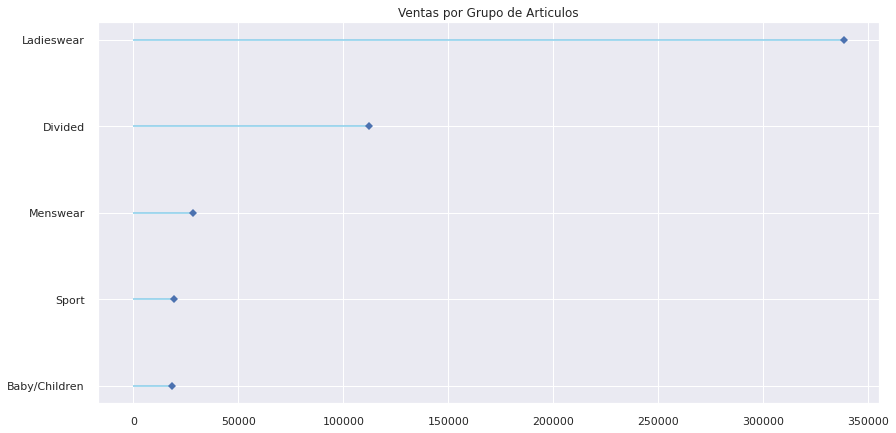

In [42]:
# Reorder it based on the values:
fig, ax = plt.subplots(figsize=(14,7))
ordered_df = aux2.sort_values(by='ventas')
my_range=range(1,len(aux2.index)+1)
 
# Horizontal version
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['ventas'], color='skyblue')
plt.plot(ordered_df['ventas'], my_range, "D")
plt.yticks(my_range, ordered_df['index_group_name'])
plt.title("Ventas por Grupo de Articulos")
plt.show()

In [43]:
aux3 = transactions.groupby(['t_dat', 'sales_channel_id'], as_index=False).agg(ventas=('price', sum))
aux3["sales_channel_id"] = aux3['sales_channel_id'].replace([1, 2], ['Store', 'Online'])

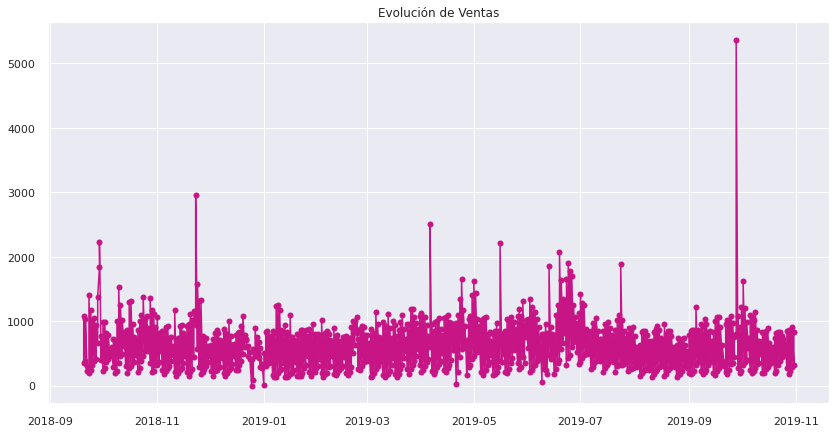

In [44]:
fig, ax = plt.subplots(figsize=(14,7))
plt.plot( 't_dat', 'ventas', data=aux3, marker='o', color='mediumvioletred')
plt.title("Evolución de Ventas")
plt.show()

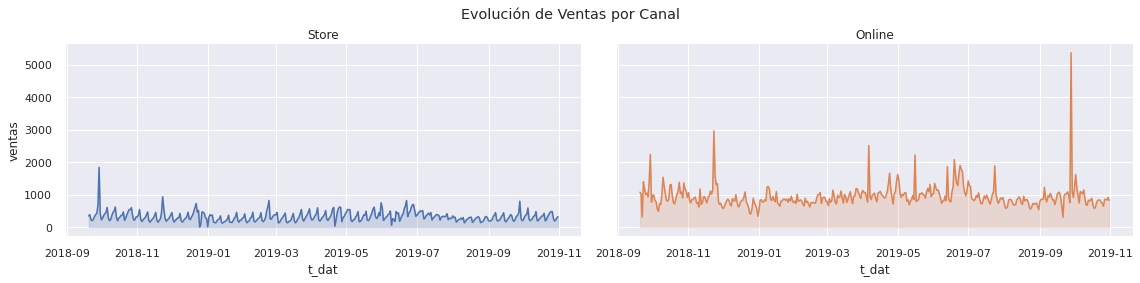

In [45]:
# Create a grid : initialize it
g = sns.FacetGrid(aux3, col='sales_channel_id', hue='sales_channel_id', col_wrap=2, height=4, aspect=2)

# Add the line over the area with the plot function
g = g.map(plt.plot, 't_dat', 'ventas')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 't_dat', 'ventas', alpha=0.2).set_titles("{col_name} Cluster")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.85)
g = g.fig.suptitle('Evolución de Ventas por Canal')

# Show the graph
plt.show()

In [46]:
ventaspdia= transactions.groupby(['t_dat'], as_index=False).agg(ventas=('price', sum))
ventaspdia.sort_values(by ='ventas', ascending=False).head(15)

,t_dat,ventas
373,2019-09-28,6161.603068
9,2018-09-29,4071.381305
64,2018-11-23,3891.939441
198,2019-04-06,3100.904898
238,2019-05-16,2593.487271
272,2019-06-19,2476.714254
266,2019-06-13,2340.517932
277,2019-06-24,2332.485373
279,2019-06-26,2296.185915
278,2019-06-25,2251.667508


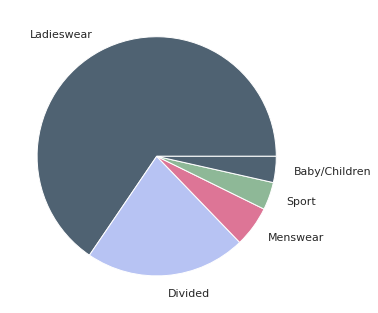

In [47]:
dfg = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name']], on="article_id", how='inner')
dfg = dfg.groupby('index_group_name', as_index=False).agg(ventas=('price', sum), precio_promedio=('price', 'mean'))
dfg = dfg.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfg.ventas, labels=dfg.index_group_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

In [48]:
dfg

,index_group_name,ventas,precio_promedio
2,Ladieswear,338189.077661,0.029122
1,Divided,112120.086051,0.026449
3,Menswear,28489.158034,0.028038
4,Sport,19338.326407,0.028570
0,Baby/Children,18220.176661,0.019241


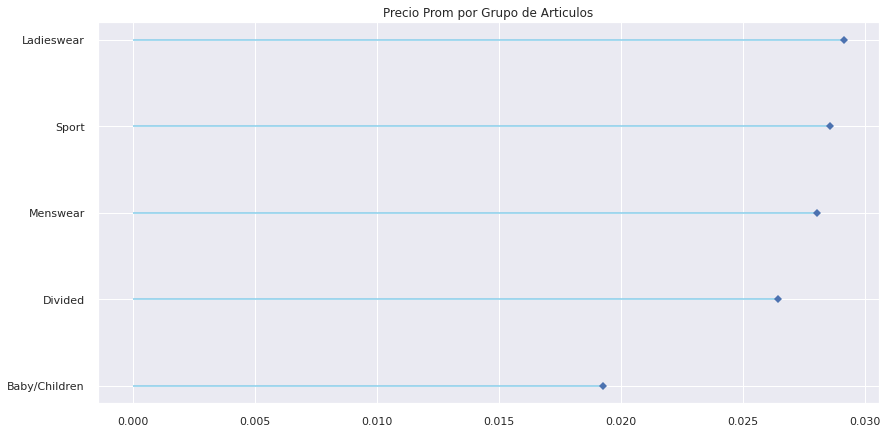

In [49]:
# Reorder it based on the values:
fig, ax = plt.subplots(figsize=(14,7))
ordered_df = dfg.sort_values(by='precio_promedio')
my_range=range(1,len(aux2.index)+1)
 
# Horizontal version
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['precio_promedio'], color='skyblue')
plt.plot(ordered_df['precio_promedio'], my_range, "D")
plt.yticks(my_range, ordered_df['index_group_name'])
plt.title("Precio Prom por Grupo de Articulos")
plt.show()

In [50]:
dfm = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfm = dfm.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfm = dfm.sort_values(by = 'ventas', ascending=False).head(15)

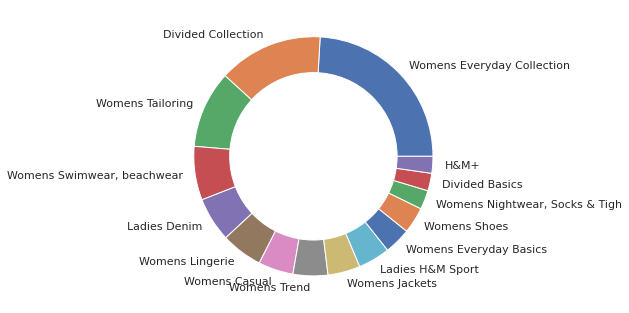

In [51]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfm["ventas"], labels=dfm["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

**Construcción de Datos**

In [52]:
customers['club_member_status'] = customers['club_member_status'].replace({np.nan :0, 'PRE-CREATE':1, 'ACTIVE':2, 'LEFT CLUB':-1})

In [53]:
ohe = transactions.groupby(['customer_id','sales_channel_id'], as_index=False).agg(Cantidad=('n_trans', 'nunique'))

In [54]:
ohe = pd.pivot_table(ohe, values='Cantidad', index='customer_id', columns=['sales_channel_id'], fill_value=0)

In [55]:
df = transactions.groupby('customer_id').agg(
    precio_promedio=('price', 'mean'),
    compras_totales=('price', sum),
    cantidad_compras=('t_dat', 'nunique'),
    # Get max of the duration column for each group
    #fecha_ultima_compra=('t_dat', max),
    # Get min of the duration column for each group
    #fecha_primer_compra=('t_dat', min),
    # Apply a lambda to date column
    antiguedad=("t_dat", lambda x: (max(x) - min(x)).days) 
)

In [56]:
df['promedio_dias_compra'] = transactions['previous_visit'] = transactions.groupby(['customer_id'])['t_dat'].shift()
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['t_dat'] - transactions['previous_visit']
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['days_bw_visits'].apply(lambda x: x.days)
df['promedio_dias_compra'] = transactions.groupby('customer_id')['days_bw_visits'].agg('mean')

df = pd.merge(df, customers[['customer_id','Active','FN' ,'age', 'club_member_status']], on="customer_id", how = 'left')
df['unica_compra'] = np.where(df['cantidad_compras'] == 1, '1', '0')
#df.fillna(axis=1).fillna(0)


In [57]:
df['promedio_dias_compra'].mean()

14.231833653833714

In [58]:
df = pd.merge(df, ohe, on="customer_id", how='left')

#df.fillna(0)

In [59]:
df.rename(columns={1: "Store", 2: "Online"},inplace=True,)

In [60]:
#dias_ult_compra = transactions.groupby('customer_id', as_index=False).agg(Cantidad=('t_dat', 'max'))
#import datetime   
#max_date = datetime.datetime(2020, 9, 22) 
#dias_ult_compra['dias'] = max_date - dias_ult_compra['Cantidad']
#dias_ult_compra['dias'] = dias_ult_compra['dias'].dt.days

In [61]:
#df = pd.merge(df, dias_ult_compra[['customer_id', 'dias']], on="customer_id", how='inner')

In [62]:
df

,customer_id,precio_promedio,compras_totales,cantidad_compras,antiguedad,promedio_dias_compra,Active,FN,age,club_member_status,unica_compra,Store,Online
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.037117,0.408288,6,275,27.500000,0.0,0.0,49,2,0,2,4
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.033947,1.765220,17,398,7.803922,0.0,0.0,25,2,0,2,16
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.036424,0.145695,3,162,54.000000,0.0,0.0,24,2,0,0,3
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492,0.060983,1,0,0.000000,0.0,0.0,54,2,1,0,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.035647,0.213881,4,362,72.400000,1.0,1.0,52,2,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049302,ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae...,0.029367,0.088102,1,0,0.000000,1.0,1.0,22,2,1,1,0
1049303,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,0.122017,0.122017,1,0,NaN,1.0,1.0,21,2,1,1,0
1049304,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.028576,0.657237,3,53,2.409091,0.0,0.0,24,2,0,1,2
1049305,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.020758,0.726525,8,379,11.147059,0.0,0.0,21,2,0,5,3


In [63]:
val_nulos(df)

,Missing Values
customer_id,0
precio_promedio,0
compras_totales,0
cantidad_compras,0
antiguedad,0
promedio_dias_compra,103154
Active,0
FN,0
age,0
club_member_status,0


In [64]:
df['promedio_dias_compra'] = df['promedio_dias_compra'].fillna(df['promedio_dias_compra'].mean())

In [65]:
#temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_name']], on="article_id", how='inner')
#temp = temp.dropna()
#ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_name)
#ca_matrix = pd.DataFrame(ca_matrix)

In [66]:
# selecting numerical columns
num_cols = df[['precio_promedio', 'compras_totales','promedio_dias_compra','Active', 'club_member_status' ,'age','Store','Online', 'unica_compra', 'antiguedad']]
#num_cols = df8.select_dtypes(include=np.number).columns.tolist()

*Precio promedio*

<AxesSubplot:xlabel='precio_promedio'>

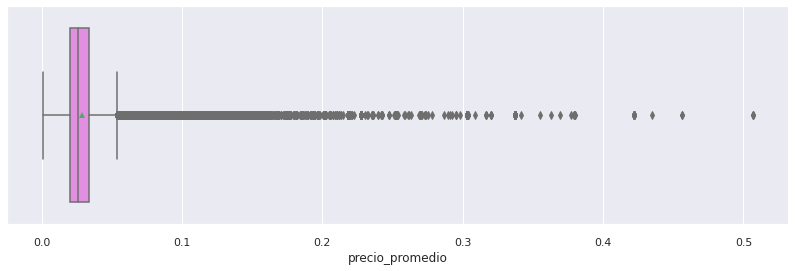

In [67]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="precio_promedio", showmeans=True, color="violet")

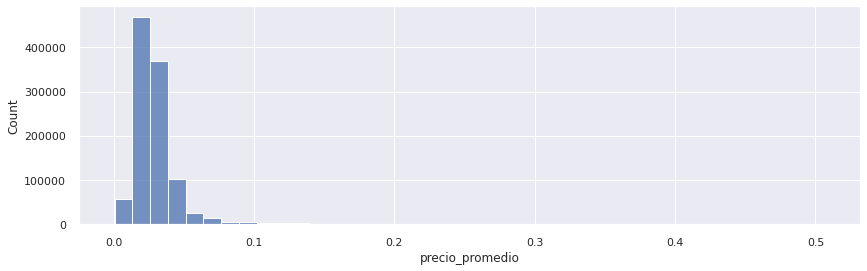

In [68]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="precio_promedio", bins=40)
plt.show()

In [69]:
for x in ['precio_promedio']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan


*Gasto Total*

<AxesSubplot:xlabel='compras_totales'>

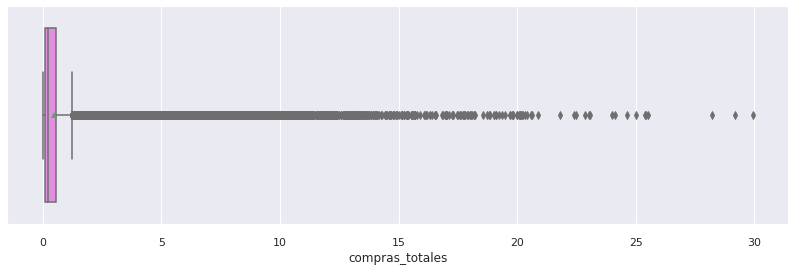

In [70]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="compras_totales", showmeans=True, color="violet")

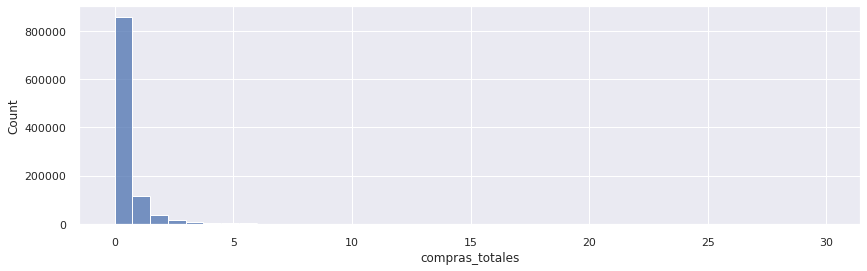

In [71]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="compras_totales", bins=40)
plt.show()

In [72]:
for x in ['compras_totales']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Promedio de dias entre cada compra*

<AxesSubplot:xlabel='promedio_dias_compra'>

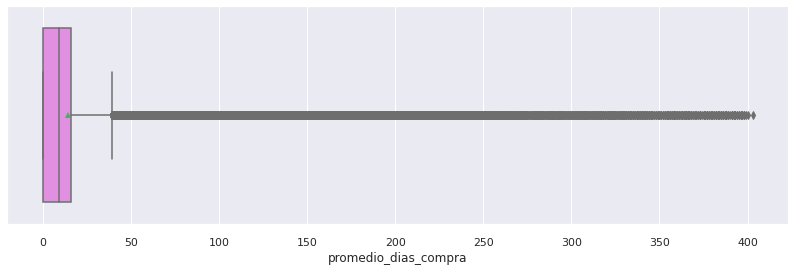

In [73]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="promedio_dias_compra", showmeans=True, color="violet")

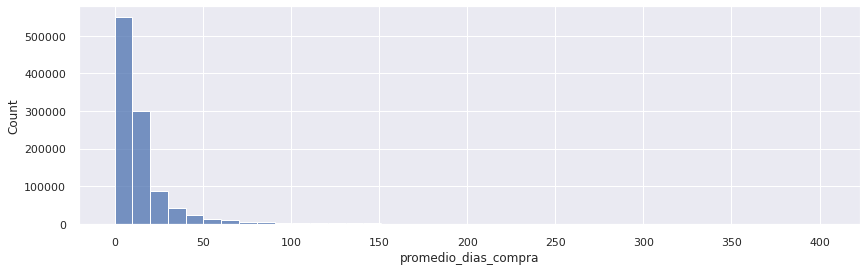

In [74]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="promedio_dias_compra", bins=40)
plt.show()

In [75]:
for x in ['promedio_dias_compra']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Cantidad de Compras en Tienda*

<AxesSubplot:xlabel='Store'>

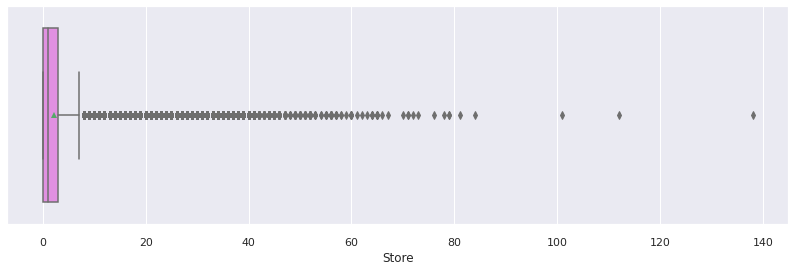

In [76]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="Store", showmeans=True, color="violet")

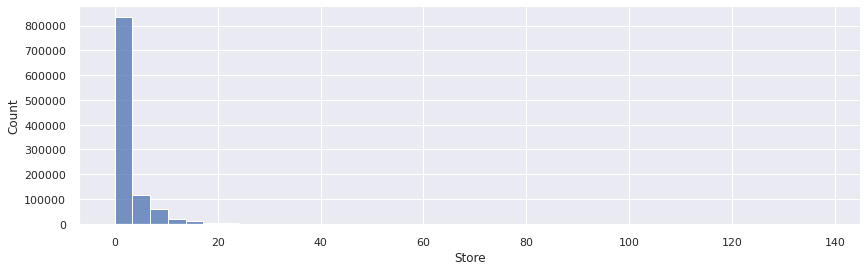

In [77]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="Store", bins=40)
plt.show()

In [78]:
for x in ['Store']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Cantidad de compras Online*

<AxesSubplot:xlabel='Online'>

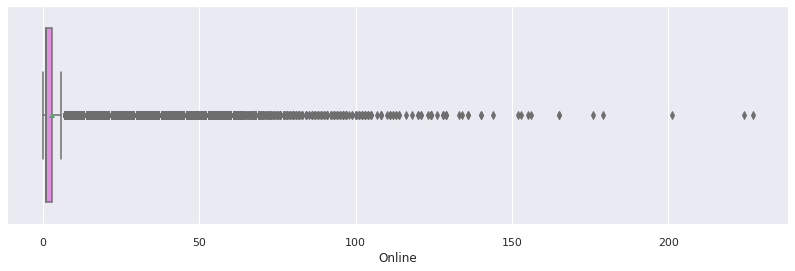

In [79]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="Online", showmeans=True, color="violet")

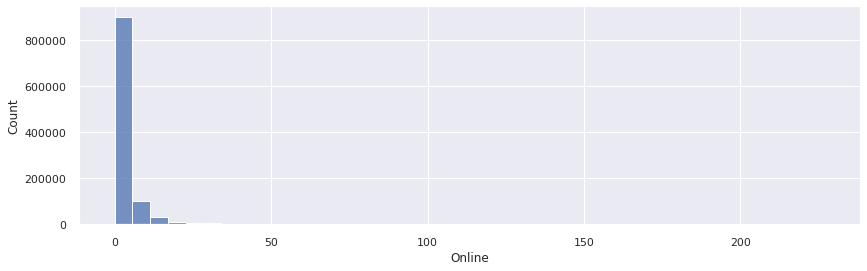

In [80]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="Online", bins=40)
plt.show()

In [81]:
for x in ['Online']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Antiguedad*

<AxesSubplot:xlabel='antiguedad'>

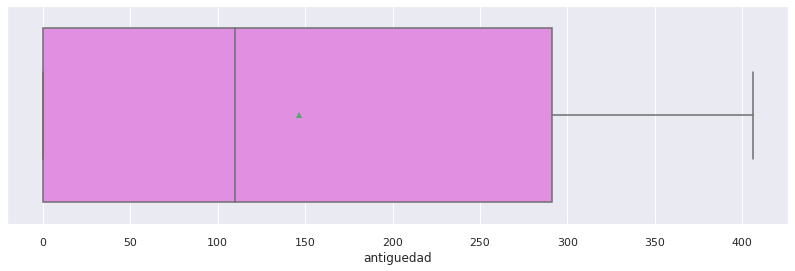

In [82]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="antiguedad", showmeans=True, color="violet")

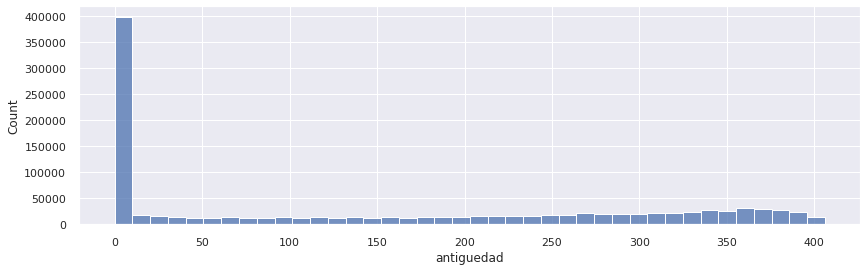

In [83]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="antiguedad", bins=40)
plt.show()

In [84]:
for x in ['antiguedad']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Age*

<AxesSubplot:xlabel='age'>

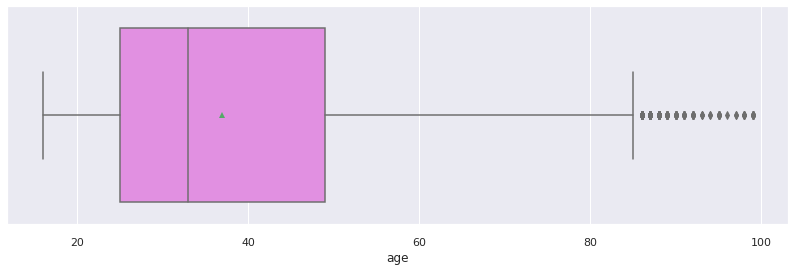

In [85]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="age", showmeans=True, color="violet")

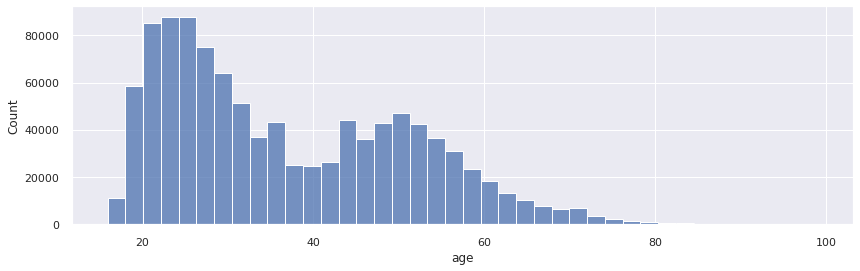

In [86]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="age", bins=40)
plt.show()

In [87]:
for x in ['age']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

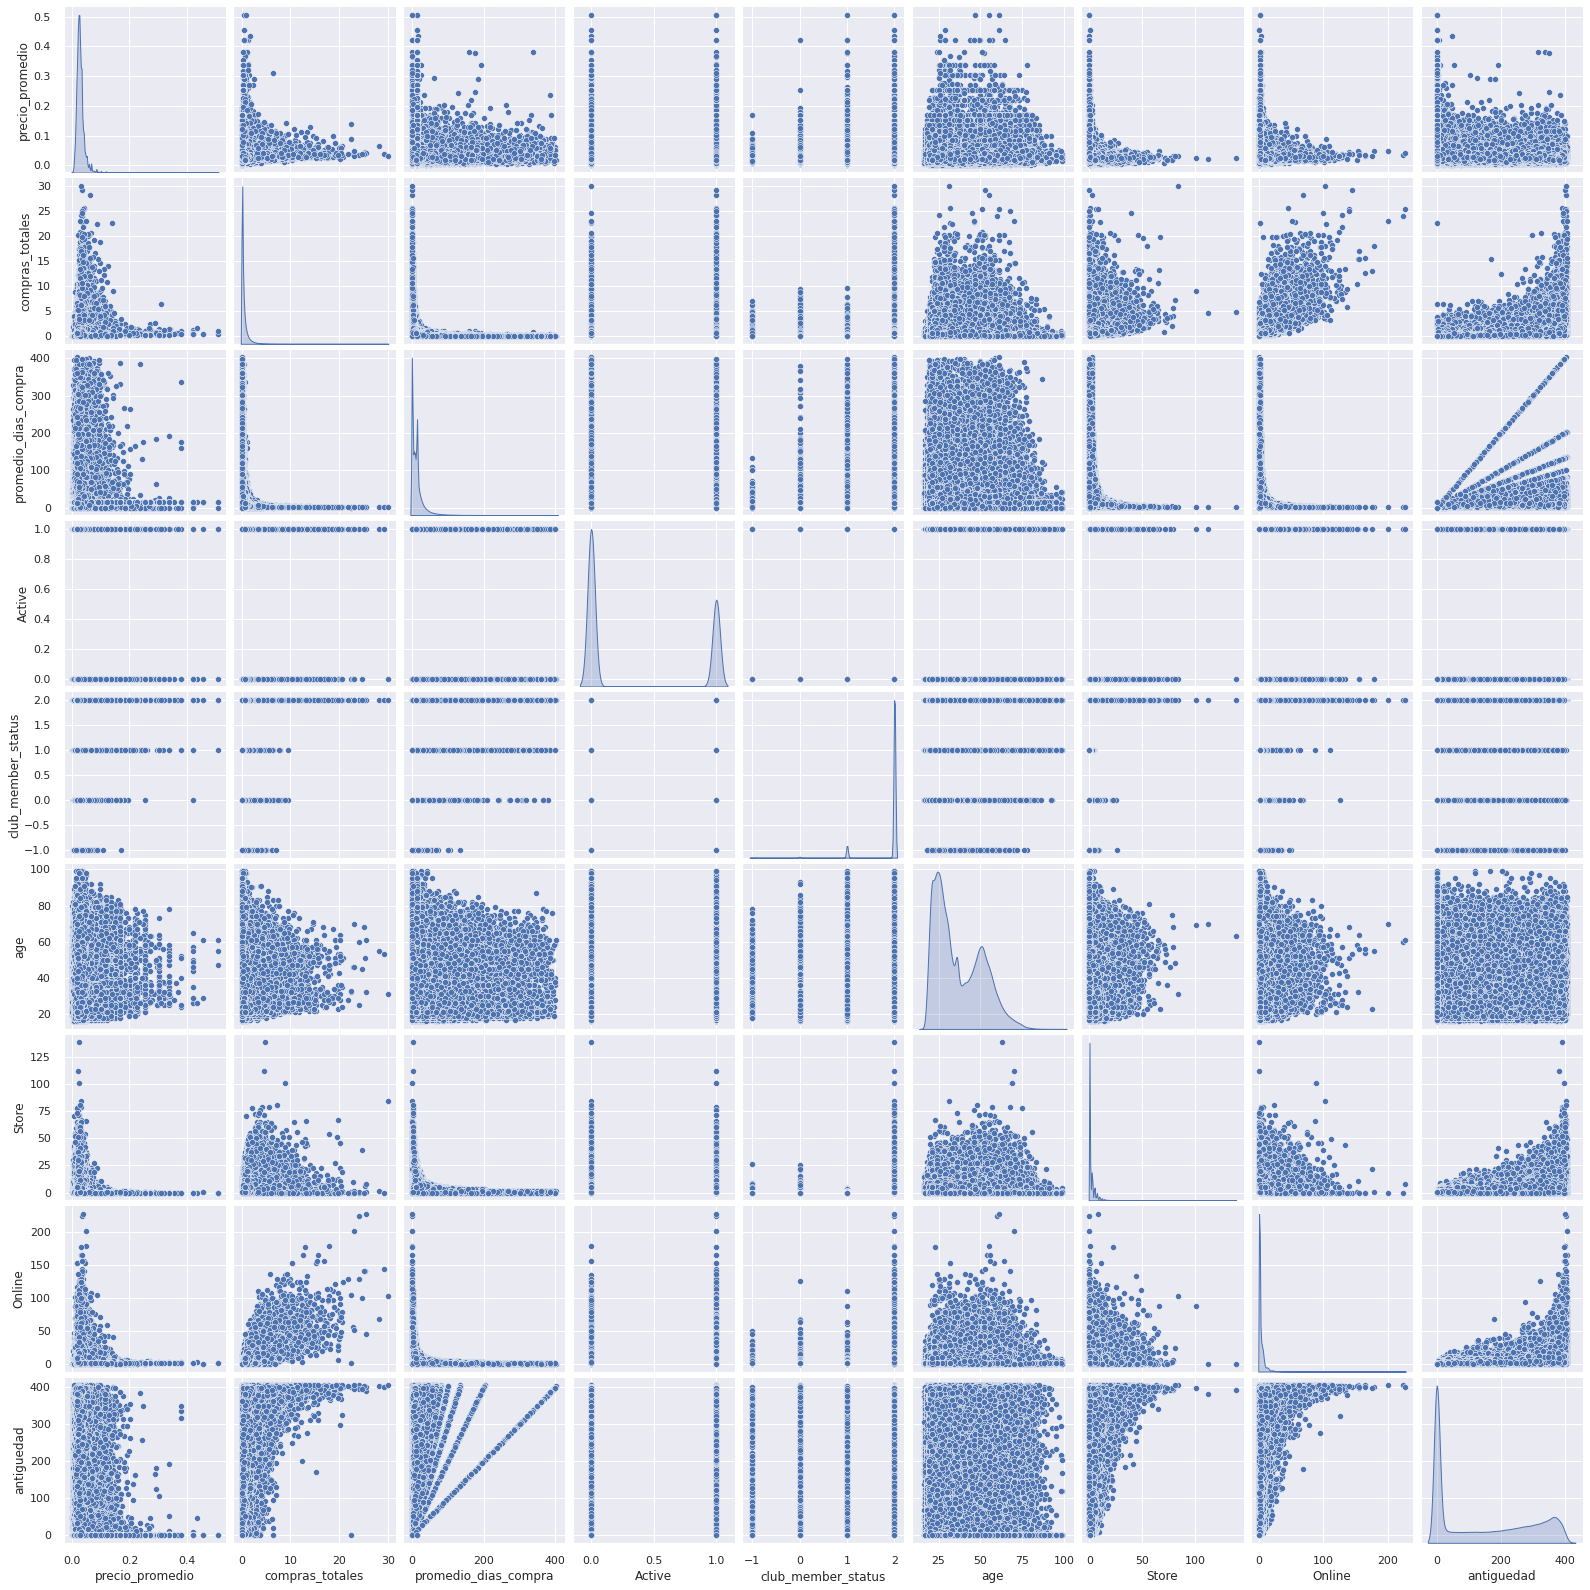

In [88]:
sns.pairplot(num_cols,diag_kind="kde")

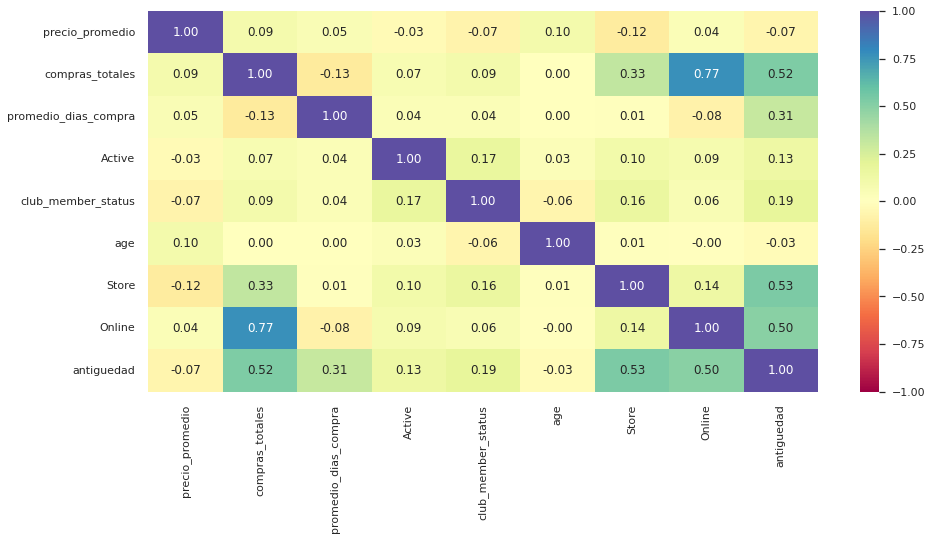

In [89]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    num_cols.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

In [ ]:
#df['promedio_dias_compra'].replace(to_replace = 0, value = df['promedio_dias_compra'].mean(), inplace=True)

# **4. Modelado**

---



In [90]:
dfcluster = num_cols
dfcluster = dfcluster.fillna(0)
#outliers(dfcluster)

In [91]:
scaler = StandardScaler()
dfcluster = scaler.fit_transform(dfcluster)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f8e3e655b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.8/dist-packages/numpy.libs/libopenblas64_p-r0-2f7c42d4.3.18.so: cannot open shar

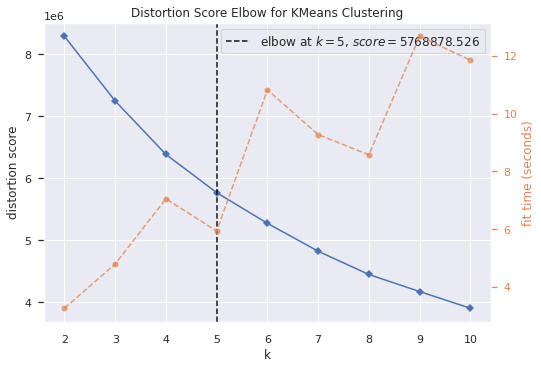

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
kmeanModel = KMeans()
elb_visualizer = KElbowVisualizer(kmeanModel, k=(2,11))
elb_visualizer.fit(dfcluster)    
elb_visualizer.show() 

In [94]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(dfcluster)
predict=kmeans.predict(dfcluster)

In [95]:
df["Cluster"] = kmeans.labels_

In [96]:
results = df.groupby(['Cluster'], as_index = False).agg(
    Cantidad=('customer_id', 'count'),    
    precio_promedio=('precio_promedio', 'mean'),
    compras_totales=('compras_totales', sum),    
    antiguedad=('antiguedad', 'mean'),
    #min_antiguedad=('antiguedad', 'min'),
    #max_antiguedad=('antiguedad', 'max'),    
    promedio_dias_compras=('promedio_dias_compra', 'mean'),  
    age=('age', 'mean'),
    #store=('Store', 'mean'),
    #online=('Online', 'mean'),
    #baby_children=('Baby/Children', 'mean'),
    #Ladieswear	=('Ladieswear', 'mean'),  
    #Menswear=('Menswear', 'mean'),
    #Divided=('Divided', 'mean'),
    club_member_status=('club_member_status', 'mean'),    
    Active=('Active', 'mean'), 
    Store =('Store', 'mean'),  
    Online =('Online', 'mean'), 
    unica_compra =('unica_compra', 'mean')
)

In [97]:
results

,Cluster,Cantidad,precio_promedio,compras_totales,antiguedad,promedio_dias_compras,age,club_member_status,Active,Store,Online,unica_compra
0,0,355995,0.026485,134514.103797,207.963089,13.562206,35.862297,1.999640,0.000000,1.961392,2.070885,0.0
1,1,241282,0.026077,92590.618661,222.377716,14.192113,36.946700,1.999801,1.000000,2.141383,2.113960,0.0
2,2,62437,0.030802,3772.901051,358.567180,4.831500,37.609719,1.995996,0.462979,2.284017,4.487723,inf
3,3,311230,0.025965,29771.636847,0.005661,4.013379,37.072719,2.000000,0.314796,0.390104,0.613826,inf
4,4,78363,0.028396,13224.214644,45.629723,6.564651,40.326248,0.920830,0.058918,0.015141,1.536215,inf


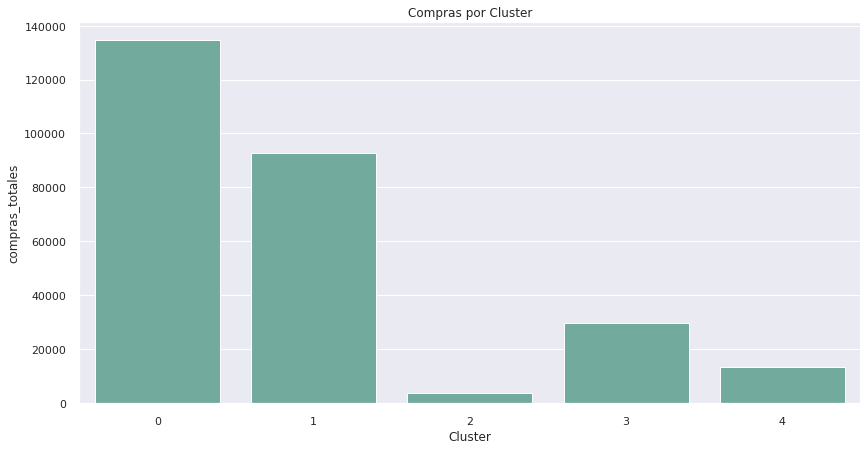

In [98]:
plt.figure(figsize = (14,7))
sns.set_color_codes("pastel")
sns.barplot(x = 'Cluster', y="compras_totales", data=results, color='#69b3a2')
plt.title(f'Compras por Cluster')
plt.show()

In [99]:
aux5 = pd.merge(transactions[["customer_id", 't_dat', 'article_id' ,'price']], df[["customer_id",'Cluster']], on="customer_id", how='inner')
aux5 = pd.merge(aux5, articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
aux1 = aux5.groupby(['t_dat', 'Cluster'], as_index=False).agg(ventas=('price', sum))

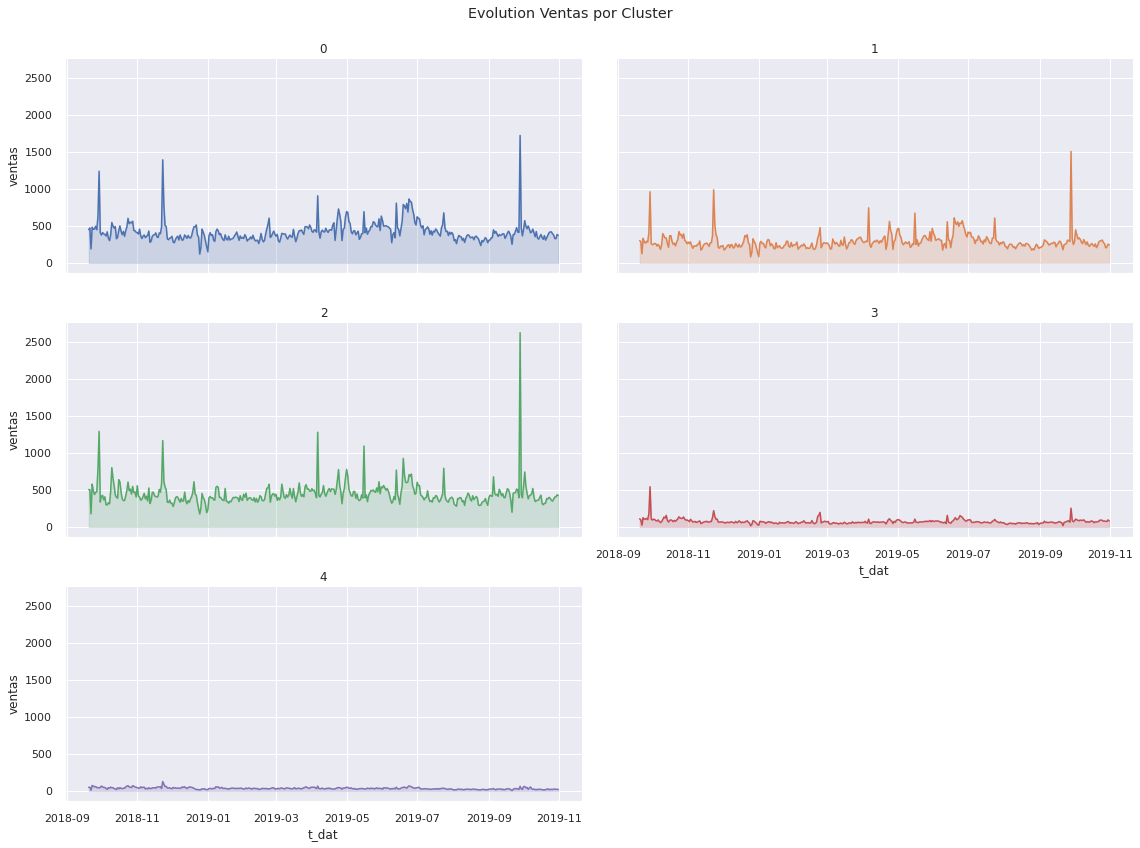

In [100]:
# Create a grid : initialize it
g = sns.FacetGrid(aux1, col='Cluster', hue='Cluster', col_wrap=2, height=4, aspect=2)

# Add the line over the area with the plot function
g = g.map(plt.plot, 't_dat', 'ventas')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 't_dat', 'ventas', alpha=0.2).set_titles("{col_name} Cluster")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Evolution Ventas por Cluster')

# Show the graph
plt.show()

**Cluster 0**  

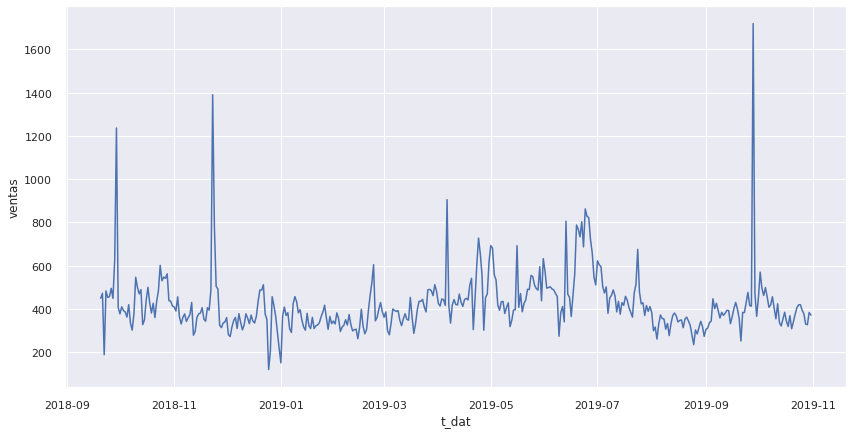

In [101]:
aux5cluster0 = aux1[aux1['Cluster']==0]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster0, x='t_dat', y='ventas')

# show graph
plt.show()

**Cluster 1**  

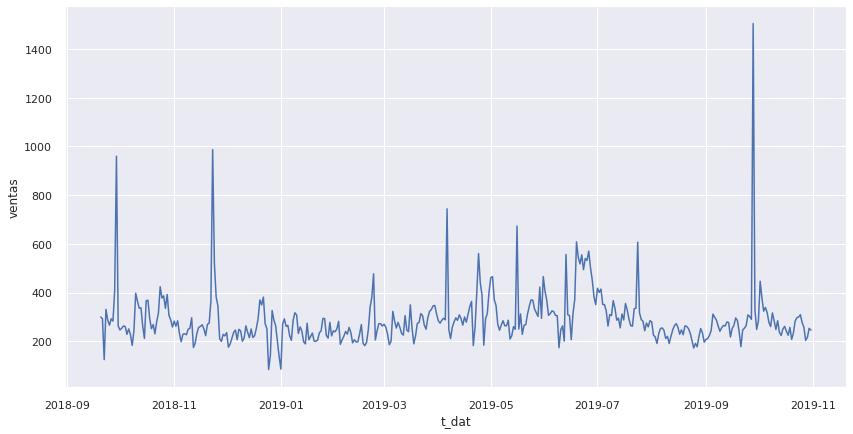

In [102]:
aux5cluster1 = aux1[aux1['Cluster']==1]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster1, x='t_dat', y='ventas')

# show graph
plt.show()

**Cluster 2** 

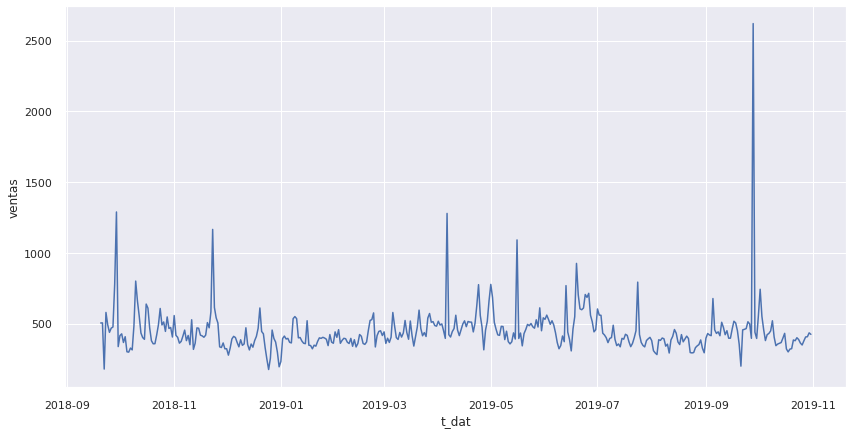

In [103]:
aux5cluster2 = aux1[aux1['Cluster']==2]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster2, x='t_dat', y='ventas')

# show graph
plt.show()

**Cluster 3** 

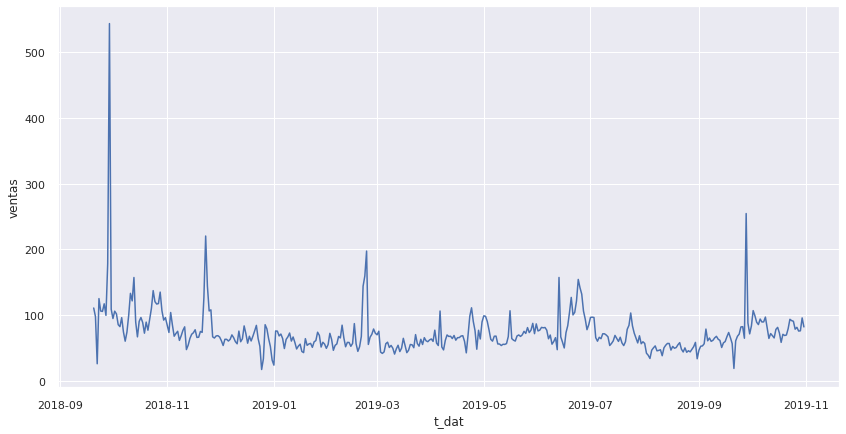

In [104]:
aux5cluster3 = aux1[aux1['Cluster']==3]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster3, x='t_dat', y='ventas')

# show graph
plt.show()

**Cluster 4** 

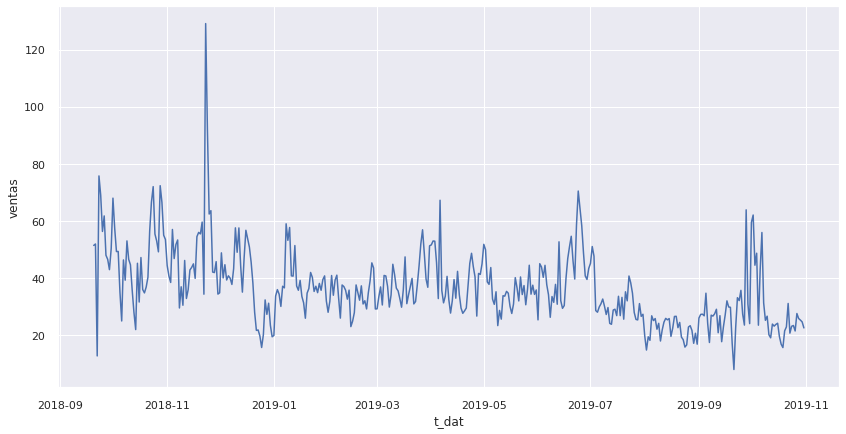

In [105]:
aux5cluster4 = aux1[aux1['Cluster']==4]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster4, x='t_dat', y='ventas')

# show graph
plt.show()

# **5. Insights**

---




*   Cluster 0 - Es el segmento de clientes con más ventas, así como el cluster con mayor cantidad de clientes. No tiene comunicación activa con la empresa. Realiza compras en forma continua. Prefiere la compra online sobre la presencial. 


*   Cluster 1 - Es el segundo cluster con más cantidad de ventas. Similar al cluster anterior, con la diferencia que no se observan preferencias entre las compras online o presencial. Cluster muy activo en comunicaciones con la empresa.

*   Cluster 2 - Es el segmento con menor cantidad de clientes y ventas. Realizan compras de manera seguida a un precio promedio alto. 

*   Cluster 3 - Es el segundo cluster con mayor cantidad de clientes. Por el detalle de antigüedad, se observa que son clientes que han realizado una única compra. Este segmento de clientes son considerados los clientes a recuperar. Además, se pueden analizar la causas de no haber repetido compras, posibles fallas comerciales, defectos en mercaderia, mala experiencia, etc. Se logra observar que las ventas de este segmento de clientes no son constantes, se observan ciertos picos que indican el aumento de ventas por fecha promocionales que motivan a la compra.

*   Cluster 4 - Este ultimo cluster es otro de los clusters con menor cantidad de ventas. A diferencia del grupo anterior, este no ha realizado una única compra, sino que realiza compras en forma esporádica, y con un plazo máximo de tiempo entre la primer y última compra de 45 días. Se logra observar en gráfico que las ventas de este segmento son constantes.